In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#use latest spark version
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install -q pyspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"



```
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
```



In [0]:
import findspark
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext

spark.stop()
conf = SparkConf().setAppName("App")

conf = (conf.setMaster('local[*]')
        .set('spark.executor.memory', '4G')
        .set('spark.driver.memory', '45G')
        .set('spark.driver.maxResultSize', '10G')
        .set('spark.task.maxFailures','1'))

findspark.init()
spark = SparkContext(conf=conf)
#spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
!pip install p_tqdm
!pip install fastparquet
!pip install hyperopt --upgrade

Requirement already up-to-date: hyperopt in /usr/local/lib/python3.6/dist-packages (0.2.3)


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import sqlite3
import csv
import datetime as dt
import math
import warnings
import gc
import random
import pickle
import pyspark

from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_val_score

from collections import Counter
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sqlalchemy import create_engine
warnings.filterwarnings('ignore')
from tqdm import tqdm,tnrange

from hyperopt import hp,fmin,tpe,STATUS_OK,space_eval,SparkTrials

```
#Code for extending ram in colab
d=[]
while(1):
  d.append('1')
```





```
function ClickConnect(){
    console.log("Clicked on connect button"); 
    document.querySelector("colab-connect-button").click()
}
setInterval(ClickConnect,60000)
```



In [0]:
#Reading the data from kaggle

!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v
  
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"vinodkumar9576","key":"af074010bd4c7bb75f9d1fe71f31452d"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c quora-question-pairs

# To find the list of file names in zip file
#for name in zip_file.namelist():
#    print ('%s' % (name))
#zip_file.close()

#Found this code snipper for reading files in a zipfile within a zipfile.
#https://stackoverflow.com/questions/11930515/unzip-nested-zip-files-in-python?noredirect=1&lq=1

import zipfile
from io import BytesIO
import re

with zipfile.ZipFile('/content/quora-question-pairs.zip', "r") as z:
  with z.open('train.csv.zip') as z2:
    z2_filedata = BytesIO(z2.read())
    with zipfile.ZipFile(z2_filedata) as nested_zip:
      qstns_train = pd.read_csv(nested_zip.open('train.csv'))
  with z.open('test.csv.zip') as z3:
    z3_filedata = BytesIO(z3.read())
    with zipfile.ZipFile(z3_filedata) as nested_zip2:
      qstns_test = pd.read_csv(nested_zip2.open('test.csv'),dtype = {"test_id":object,"question1":object,"question2":object})

#print("qstns_train :",end='\n')
#print(qstns_train.head(2))
#print("qstns_test :",end='\n')
#print(qstns_test.head(2))

Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
     |████████████████████████████████| 1.4MB 9.2MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 3.8 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72859 sha256=e7eda32e45956d98400a1388b88680000baff0b7ef42c4c98eac6226aa8b40df
  Stored in directory: /root/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01
Successfully built kaggle
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.6/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.6/dist-packages/kaggle/api/kaggle_api_extended.py", line 149, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure

In [0]:
#Original train data
qstns_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [0]:
#test data
qstns_test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [0]:
qstns_train.shape

(404290, 6)

In [0]:
#shape of text data
qstns_test.shape

(3563475, 3)

<h1>4. Machine Learning Models </h1>

In [0]:
if os.path.isfile('/content/drive/My Drive/Colab Notebooks/Models/Quora/final_features/final_features.parquet.gzip'):
  final_features = pd.read_parquet('/content/drive/My Drive/Colab Notebooks/Models/Quora/final_features/final_features.parquet.gzip', engine='fastparquet')
else:
  print('final_features file is not existing in Drive. Run previous notebook')

In [0]:
final_features.head(1)

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,len_q1,len_q2,n_words_q1,n_words_q2,words_Common,words_Total,word_Share,freq_q1+q2,freq_q1-q2,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,...,260_y,261_y,262_y,263_y,264_y,265_y,266_y,267_y,268_y,269_y,270_y,271_y,272_y,273_y,274_y,275_y,276_y,277_y,278_y,279_y,280_y,281_y,282_y,283_y,284_y,285_y,286_y,287_y,288_y,289_y,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,0,0,0.99998,0.833319,0.999983,0.999983,0.916659,0.916659,0.0,1.0,2.0,13.0,100,93,93,100,0.982456,1,1,66,57,14,12,10.0,10.0,0.434783,2,2,-5.856872,17.449559,4.86272,7.971019,20.345586,-5.514759,-4.0778,-2.820742,8.029026,146.599092,-45.501892,-3.234358,...,-1.490777,6.133633,8.453127,2.723381,6.025675,-28.799432,5.911213,0.715092,26.158372,3.577201,-2.053691,2.117856,-4.933909,-16.165107,-7.292672,-4.659052,-2.085703,3.761888,13.230259,1.065335,0.559134,9.310662,-3.011264,3.997825,1.174759,-13.503914,2.716392,-4.664858,3.23862,3.586218,-17.810438,7.231024,1.531186,-7.528823,0.473802,-11.864658,-11.293788,1.866265,3.616046,11.971096


* Sampling 100000 rows from final_features to work on before modifying the features.

In [0]:
fnl_ft_samp = final_features.sample(100001)

In [0]:
#Making final_features to hold only features and assign the is_duplicate to 'y' and drop rest columns

#Removing index 0 and making indexes from 1
fnl_ft_samp.reset_index(inplace=True)
fnl_ft_samp.drop(final_features.index[0], inplace=True)

#storing o/p values in y_true
y_true_samp = fnl_ft_samp['is_duplicate']

#dropping id,is_duplicate columns
fnl_ft_samp.drop(['id', 'index', 'is_duplicate'],  axis=1, inplace=True)

In [0]:
fnl_ft_samp.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,len_q1,len_q2,n_words_q1,n_words_q2,words_Common,words_Total,word_Share,freq_q1+q2,freq_q1-q2,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,...,260_y,261_y,262_y,263_y,264_y,265_y,266_y,267_y,268_y,269_y,270_y,271_y,272_y,273_y,274_y,275_y,276_y,277_y,278_y,279_y,280_y,281_y,282_y,283_y,284_y,285_y,286_y,287_y,288_y,289_y,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
1,0.499988,0.153845,0.599988,0.599988,0.555549,0.555549,0.0,0.0,20.0,19.0,68,37,33,53,0.250000,1,1,152,55,28,9,3.0,3.0,0.090909,2,2,-10.833008,25.587500,-8.664667,6.001064,15.947522,21.521090,7.261835,-33.937334,-8.043690,264.062621,-13.057046,4.053252,21.614447,7.192316,...,9.429198,-3.639595,-4.399318,6.449402,12.653248,-7.553686,-0.029726,-6.645100,-1.690849,9.882582,3.742059,-23.395486,2.602225,-7.092099,1.008964,3.363896,4.750315,-0.592914,-10.994502,5.590758,0.824855,-3.723211,-6.933198,-11.049665,5.306613,8.879243,4.576551,-7.450109,2.575761,-4.197465,-21.085756,2.741243,-0.492050,-12.195719,15.425051,-0.358959,-9.097035,2.538288,-5.628592,1.432666
2,0.499975,0.142855,0.999975,0.999975,0.833319,0.833319,0.0,0.0,8.0,10.0,92,52,43,65,0.370370,5,5,68,27,14,6,5.0,5.0,0.250000,10,10,-3.766154,16.573951,6.376031,-4.217699,2.665873,-11.628884,0.707232,8.995594,-2.270044,163.149573,-16.924890,-15.709745,11.341453,-9.238908,...,3.050246,11.812418,-3.228082,9.490734,1.659613,-5.167777,4.656094,-0.955669,3.689678,12.961993,8.728345,-1.595377,2.968704,4.531897,-1.168933,7.357611,5.252827,-7.564915,-0.801741,-3.653086,0.933549,8.973127,-7.254295,-2.438592,6.789848,0.249969,5.324699,0.811172,1.477365,-2.971790,-4.202494,13.446445,-7.926283,-8.289208,11.526688,-1.734690,1.860961,-8.091130,4.625549,7.519048
3,0.999980,0.624992,0.999980,0.999980,0.999990,0.999990,1.0,1.0,3.0,11.5,100,83,83,78,0.666667,4,34,72,57,13,10,8.0,8.0,0.347826,38,38,4.638866,-1.220835,12.211520,-7.358826,1.477217,-18.634246,-4.455618,0.409066,12.336764,179.732100,0.242866,1.076963,0.096288,-15.531628,...,8.214271,4.429460,-3.808424,8.608068,9.559307,-1.834365,-5.820379,-6.847524,18.018853,4.331750,9.248852,5.248345,-3.572251,9.955669,3.864846,8.974726,9.903937,9.857625,1.437519,0.513633,0.329321,-2.047094,-17.481212,6.666086,4.341386,-6.403166,1.284808,5.258065,-1.194916,14.069180,-5.180460,5.296906,1.878379,-6.392261,3.523144,-5.523528,-3.921623,-7.358249,4.343750,-7.326590
4,0.000000,0.000000,0.799984,0.799984,0.399996,0.399996,0.0,1.0,0.0,10.0,56,55,45,51,0.225000,5,1,48,47,10,12,4.0,4.0,0.190476,6,6,3.609387,-5.615587,-11.775007,10.992746,0.461636,7.562667,0.081638,-2.940728,-4.870336,78.141289,-4.170987,8.696174,1.497376,-6.135371,...,14.701142,10.001505,10.208915,-6.896912,-0.611071,-15.730164,-4.600855,7.133820,14.310911,13.012880,1.849418,-1.056810,8.538925,6.045245,-0.021129,11.655842,-3.487460,-4.117100,6.863797,-3.846438,-5.028111,9.601802,6.597850,13.450865,1.518639,4.902346,6.295923,-4.196623,-7.698220,3.618077,-20.548483,11.417606,10.741459,9.658008,-1.515422,-2.460460,3.281852,-3.952842,-11.027988,21.933035
5,0.499988,0.333328,0.000000,0.000000,0.333328,0.333328,0.0,0.0,3.0,7.5,54,54,43,52,0.388889,1,1,59,39,9,6,2.0,2.0,0.133333,2,2,-7.290927,-3.803941,-4.843013,-9.160136,-4.684735,-5.588104,1.121532,-0.230890,2.596410,79.569453,-14.258264,-13.949136,-1.785311,-15.574297,...,7.026551,13.580122,8.937210,2.692820,-2.198951,-7.385886,-0.270653,2.128018,4.010951,3.960815,-20.490676,1.342052,-13.113120,-0.921885,-13.864328,0.129650,-3.861777,13.024924,0.382584,3.203740,5.241573,7.158389,8.451574,-2.057722,14.714210,0.563120,-6.671957,-6.582682,-1.097306,-14.613634,-2.108349,-2.142005,-7.459656,1.635045,20.172937,8.055178,-0.250683,-1.808959,-10.509135,5.167773


* Since all our columns are either float or int, so no need to change the dtypes

In [0]:
fnl_ft_samp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1 to 1000
Columns: 626 entries, cwc_min to 299_y
dtypes: float64(614), int64(12)
memory usage: 4.8 MB


<h2> 4.3 Random train test split( 70:30) </h2>

In [0]:
X_train,X_test,Y_train,Y_test = train_test_split(fnl_ft_samp, y_true_samp, stratify = y_true_samp, test_size =0.3 )

In [0]:
Y_train.head()

51702    0
22426    1
916      0
69789    1
74331    0
Name: is_duplicate, dtype: int64

In [0]:
print('No. of data points in Train data : {}'.format(X_train.shape))
print('No. of data points in Test data : {}'.format(X_test.shape))

No. of data points in Train data : (70000, 626)
No. of data points in Test data : (30000, 626)


* **Plotting distributions of +/- in train & test data**

In [0]:
train_dstr = Counter(Y_train) #counts no. of pts in each category in given data like value_counts()
train_len = len(Y_train)

test_dstr = Counter(Y_test)
test_len = len(Y_test)

#printing distributions in train data
print('-'*10,'Distribution of ouput variables in train Data', '-'*10)
print('Class 0 : {} \nClass 1 : {} \n'.format(train_dstr[0]/train_len*100, train_dstr[1]/train_len*100))

#printing distributions in train data
print('-'*10,'Distribution of ouput variables in test Data', '-'*10)
print('Class 0 : {} \nClass 1 : {} '.format(test_dstr[0]/test_len*100, test_dstr[1]/test_len*100))

---------- Distribution of ouput variables in train Data ----------
Class 0 : 62.998571428571424 
Class 1 : 37.001428571428576 

---------- Distribution of ouput variables in test Data ----------
Class 0 : 63.0 
Class 1 : 37.0 


##Function for plotting confusion matrix

In [0]:
def plot_confusion_matrix(test_y,predict_y):

  #Used for plotting confusion matrix
  C = confusion_matrix(test_y,predict_y)

  #Divide each element of confusion of matrix by the sum of elements in that column
  #axis = 1 - columns
  #Used for plotting Recall
  A = ((C.T)/(C.sum(axis=1))).T

  #Divide each element of confusion matrix with the sum of elements in that row
  #axis = 1 - rows
  #Used for plotting precision
  B = ((C.T)/(C.sum(axis=0))).T 

  #Plotting
  plt.figure(figsize=(20,4))
  labels=[1,2]
  
  #Plotting Confusion matrix
  cmap = sns.light_palette('blue')
  plt.subplot(1,3,1)
  sns.heatmap(C,annot=True,cmap=cmap, fmt='.3f', xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.title('Confusion Matrix')

  #Plotting Precision
  plt.subplot(1,3,2)
  sns.heatmap(B, annot=True, cmap=cmap, fmt='.3f', xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.title('Precision Matrix')
  
  #Plotting Recall
  plt.subplot(1,3,3)
  sns.heatmap(A, annot = True, cmap=cmap, fmt='.3f', xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.title('Recall Matrix')

  plt.show()



## 4.4 Building a random model (Finding worst-case log-loss) </h2>


Log loss on Test Data using Random Model : 0.883536571641479


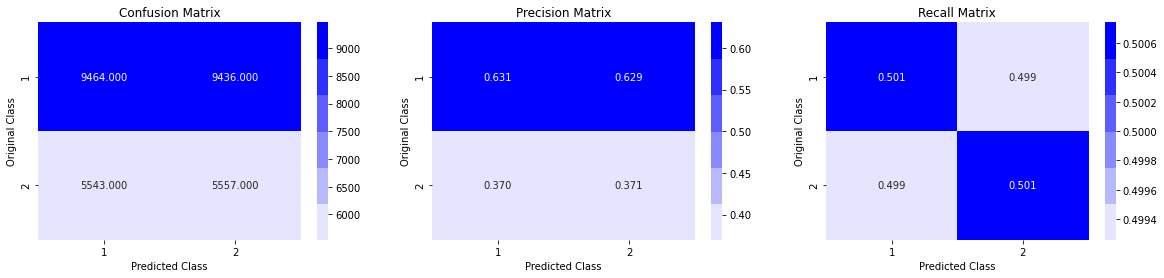

In [0]:
#we are generating random model with 9 random values that would sum upto 1.
#for that we generate 9 random numbers divide each by their total sum to get 9 numbers.
#We create outut array that has exactly same size as the CV/test data
#Taking randomly generated values as predicted values to generate Random Model

predicted_y = np.zeros((test_len,2))
for i in tnrange(test_len):
  rand_probs = np.random.rand(1,2)
  predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])

#calculating log loss
print('Log loss on Test Data using Random Model : {}'.format(log_loss(Y_test,predicted_y,eps=1e-15)))

predicted_y = np.argmax(predicted_y,axis=1)
plot_confusion_matrix(Y_test, predicted_y)

# 4.4 SGD Algos

* **Using Hyperopt**

##Functions

In [0]:
def save_best_model(model,save_name,regularizer):
  with open('/content/drive/My Drive/Colab Notebooks/Models/Quora/SGD_'+save_name+'_'+regularizer+'.pkl','wb') as SGD_pkl_file:
    pickle.dump(model, SGD_pkl_file)

In [0]:
def loss_df(search_space,trials):
  defaults = {'params' : search_space.keys()}
  params = defaults['params']
  #tid - size of data points
  results_df = pd.DataFrame(columns=['tid',*params,'status'])

  for t in trials.trials:
    result_dict = t['misc']['vals']
    #changing position list value as interger and assigning to same key
    result_dict = {k:v[0] for k,v in result_dict.items()}
    result_dict = space_eval(search_space,result_dict)
    result_dict['tid'] = t['tid']
    result_dict.update(t['result'])

    results_df = pd.concat([results_df,pd.DataFrame(result_dict,index=[0])],axis=0,ignore_index=True)
    #storing only those entries that have status 'ok
  results_df = results_df[results_df.status=='ok']
 
    #changing datatypes of columns which are having as 'object' to respectives
  results_df = results_df.infer_objects()
  indices = results_df.groupby('alpha')['loss'].idxmin()
  results_df = results_df.loc[indices].sort_values('alpha')

  return results_df

In [0]:
def opt_alpha_sgd_para(search_space):

  clf = SGDClassifier(alpha=search_space['alpha'], penalty=search_space['penalty'],loss=search_space['loss'], random_state=42)
  clf.fit(X_train,Y_train)
  sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
  sig_clf.fit(X_train,Y_train)
  #Predicting Y with test data
  Y_predict = sig_clf.predict_proba(X_test)
  #calculating log-loss
  #no need to store the log error as hyperopt default stores it
  log_error = log_loss(Y_test,Y_predict, labels = clf.classes_, eps = 1e-15)

  #below don't change the 'loss' to anyother as its used by fmin or anyother hyperopt functions.
  return {'loss' : log_error, 'status' : STATUS_OK}

In [0]:
def sgd_model_hyperopt(X_train, Y_train, X_test,Y_test,search_space,loss,regularizer,save_name):

  flag = False

  if os.path.exists('/content/drive/My Drive/Colab Notebooks/Models/Quora/SGD_'+save_name+'_'+regularizer+'.pkl'):
    with open('/content/drive/My Drive/Colab Notebooks/Models/Quora/SGD_'+save_name+'_'+regularizer+'.pkl','rb') as SGD_LOSS_PCKL:
      sig_clf = pickle.load(SGD_LOSS_PCKL)

  else:
    flag = True
    print('Saved file not found, Running the algorithm\n')
  
    #programe to trigger objective function for finding best alpha
    #Here divide the evaluation as all of the RAM is getting used
    #for the first 10 trials calculate the best, save trials in a picle file
    #for the next 10 trials, set trials = saved pickle and runt fmin again.
    #https://github.com/hyperopt/hyperopt/issues/267
    trials = SparkTrials(parallelism=2)
    best = fmin(fn=opt_alpha_sgd_para, 
            space=search_space, 
            algo=tpe.suggest, 
            max_evals=20, 
            trials = trials
           #,return_argmin=False
            )
  
    best_alpha = space_eval(search_space,best)['alpha']
    reg = space_eval(search_space,best)['penalty']

    print('\nBest alpha found is : ', best_alpha, '\n')
    print('\nPenalty is : ', reg, '\n')

    #train the model with found best alpha
    print('\nTraining model with found best alpha')
    clf = SGDClassifier(alpha=best_alpha, penalty = regularizer, loss = loss, random_state=42)
    clf.fit(X_train,Y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(X_train, Y_train)

    #Saving best model of sig_clf
    best_SGD_LOG = sig_clf
    print('\nSaving the trained model with best alpha')
    save_best_model(best_SGD_LOG, save_name,regularizer)

    #below function returns the df of error
    error_df = loss_df(search_space,trials)
    #Saving log_error
    print('\nSaving the error file')
    error_df.to_parquet('/content/drive/My Drive/Colab Notebooks/Models/Quora/Error_'+save_name+'_'+regularizer+'.parquet.gzip',compression='gzip')
  
  #from here entire code is run irrespective of algo run

  #running below to get saved error file when algo is not ran
  if not flag:
    if os.path.exists('/content/drive/My Drive/Colab Notebooks/Models/Quora/Error_'+save_name+'_'+regularizer+'.parquet.gzip'):
      error_df= pd.read_parquet('/content/drive/My Drive/Colab Notebooks/Models/Quora/Error_'+save_name+'_'+regularizer+'.parquet.gzip', engine='fastparquet')
      min_error_index = error_df['loss'].idxmin()
      best_alpha = error_df.loc[min_error_index]['alpha']
      print('\nBest alpha found from saved model : ', best_alpha,'\n')


  #plotting line plot of errors vs alpha
  f,ax = plt.subplots(figsize=(12,8))

  X_alpha = error_df['alpha']
  Y_log_ls = error_df['loss']

  sns.lineplot(x=X_alpha, y=Y_log_ls,markers=True)
  sns.scatterplot(x=X_alpha, y=Y_log_ls)

  for i,txt in enumerate(np.round(Y_log_ls,3)):
    ax.text(X_alpha.iloc[i],txt, (X_alpha.iloc[i],txt),fontsize=12)

  plt.grid()
  plt.title('Cross Validation Error for each alpha')
  plt.xlabel('Alpha i\'s')
  plt.ylabel('Error measure')
  plt.show()

  #Train log loss
  Y_predict_train = sig_clf.predict_proba(X_train)
  train_log_loss = log_loss(Y_train,Y_predict_train, labels=sig_clf.classes_, eps = 1e-15)
  print('For values of best alpha = ', best_alpha, '\nTrain log loss is :', train_log_loss, '\n')

  #Test log loss
  Y_predict_test = sig_clf.predict_proba(X_test) #returns array with probabilities of shape(len(X_test), no.classes)... all probabilites wrt each class
  test_log_loss = log_loss(Y_test,Y_predict_test, labels=sig_clf.classes_, eps = 1e-15)
  print('For values of best alpha = ', best_alpha, '\nTest log loss is :', test_log_loss, '\n')

  #Plotting confusion matrix
  predicted_Y = np.argmax(Y_predict_test,axis=1) # this gives positions of max values in each row 0:first column - class '0', 1:second column - class '1'
  print('Total number of test data points :', len(predicted_Y),'\n')
  plot_confusion_matrix(Y_test, predicted_Y)

  #returning model to use further out of function if we want
  return sig_clf,error_df


## SGD Logistic Regression

Saved file not found, Running the algorithm

100%|██████████| 100/100 [3:27:51<00:00, 124.71s/it, best loss: 0.4477620390578903]

Best alpha found is :  0.01 


Penalty is :  l2 

Training model with found best alpha


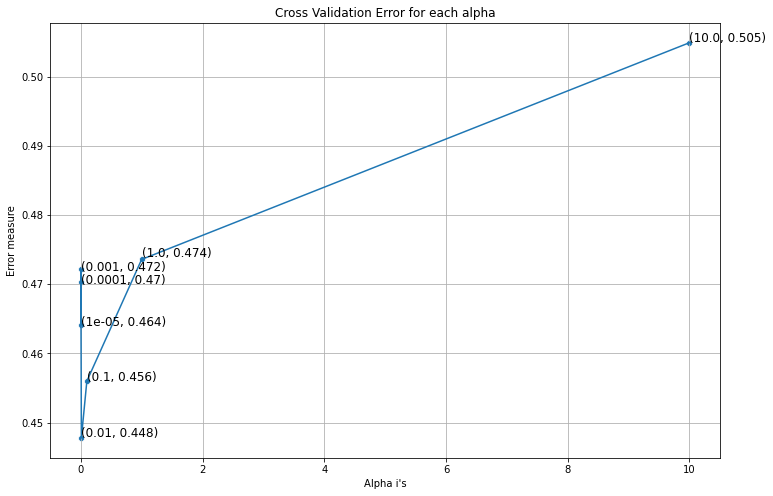

For values of best alpha =  0.01 
Train log loss is : 0.4448991093339398 

For values of best alpha =  0.01 
Test log loss is : 0.4477620390578903 

Total number of test data points : 30000 



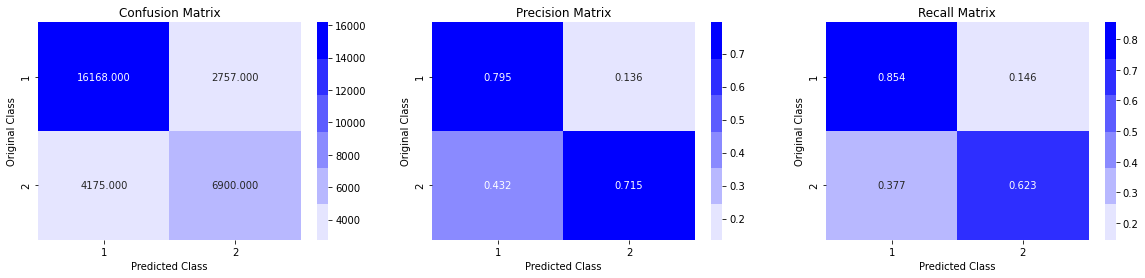

In [0]:
#driver program for logistic regression
#with l1 regularizer code took approx 6 hrs to complete 16% and also each iteration took 1000 sec
#so switching to l2 regularizer
#done using trials()

search_space = {'alpha':hp.choice('alpha',[10**x for x in range(-5,2)])
                ,'penalty':hp.choice('penalty',['l2']),
                'loss':hp.choice('loss',['log'])
                }

Log_regression,error_df = sgd_model_hyperopt(X_train, Y_train, X_test, Y_test,search_space,loss='log',regularizer='l2',save_name='Log_TfidfWeighted')

Saved file not found, Running the algorithm

100%|██████████| 20/20 [3:32:32<00:00, 637.61s/trial, best loss: 0.473627387882907]


Total Trials: 20: 20 succeeded, 0 failed, 0 cancelled.



Best alpha found is :  0.0001 


Penalty is :  l1 


Training model with found best alpha

Saving the trained model with best alpha

Saving the error file


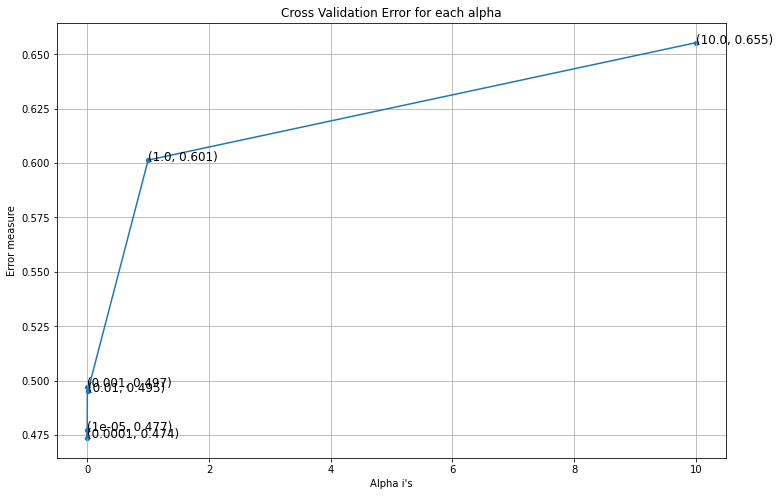

For values of best alpha =  0.0001 
Train log loss is : 0.4695658646932594 

For values of best alpha =  0.0001 
Test log loss is : 0.473627387882907 

Total number of test data points : 30000 



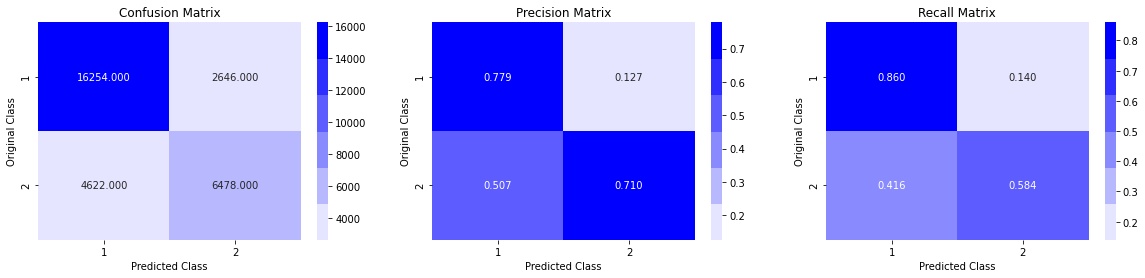

In [0]:
#SGD log loss with l1 Regularizer
search_space = {'alpha':hp.choice('alpha',[10**x for x in range(-5,2)])
                ,'penalty':hp.choice('penalty',['l1']),
                'loss':hp.choice('loss',['log'])
                }

Log_regression,error_df = sgd_model_hyperopt(X_train, Y_train, X_test, Y_test,search_space,loss='log',regularizer='l1',save_name='Log_TfidfWeighted')

## 4.4 SGD using hinge Loss(LSVM) with hyperparameter tuning


Best alpha found from saved model :  1e-05 



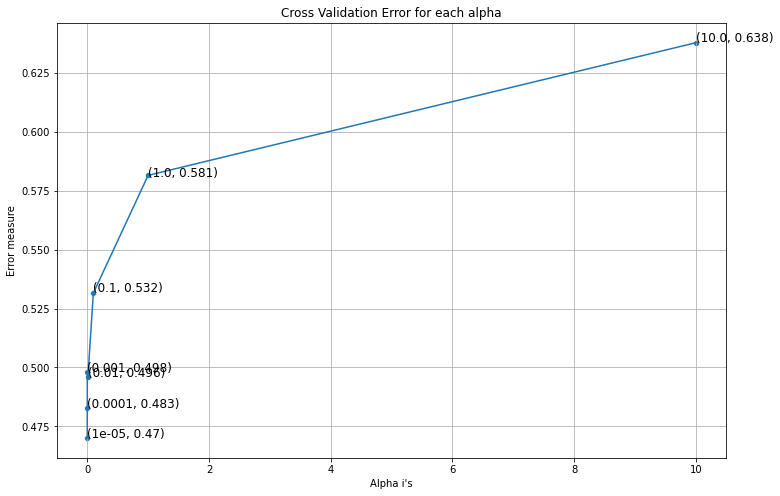

For values of best alpha =  1e-05 
Train log loss is : 0.4666082166842251 

For values of best alpha =  1e-05 
Test log loss is : 0.4700766608875914 

Total number of test data points : 30000 



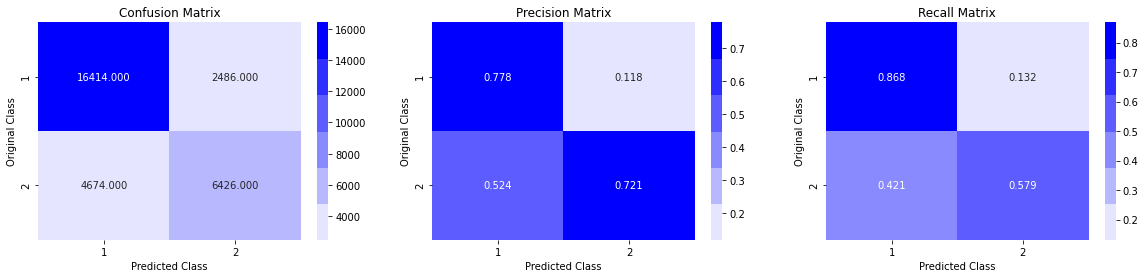

In [0]:
#driver program for linear SVM
#took nearly 4 hours to run with max_eval=20 and alpha = 6 values with log search space
#all trials got succeeded and done using sparktrials(parallelism=2)

search_space = {'alpha':hp.choice('alpha',[10**x for x in range(-5,2)])
                ,'penalty':hp.choice('penalty',['l1']),
                'loss':hp.choice('loss',['hinge'])
                }

Lr_SVM,error_df = sgd_model_hyperopt(X_train, Y_train, X_test, Y_test,search_space,loss='hinge',regularizer='l1',save_name='Hinge_TfidfWeighted')

Saved file not found, Running the algorithm

100%|██████████| 20/20 [31:49<00:00, 95.49s/trial, best loss: 0.45292476674160853] 


Total Trials: 20: 20 succeeded, 0 failed, 0 cancelled.



Best alpha found is :  0.01 


Penalty is :  l2 


Training model with found best alpha

Saving the trained model with best alpha

Saving the error file


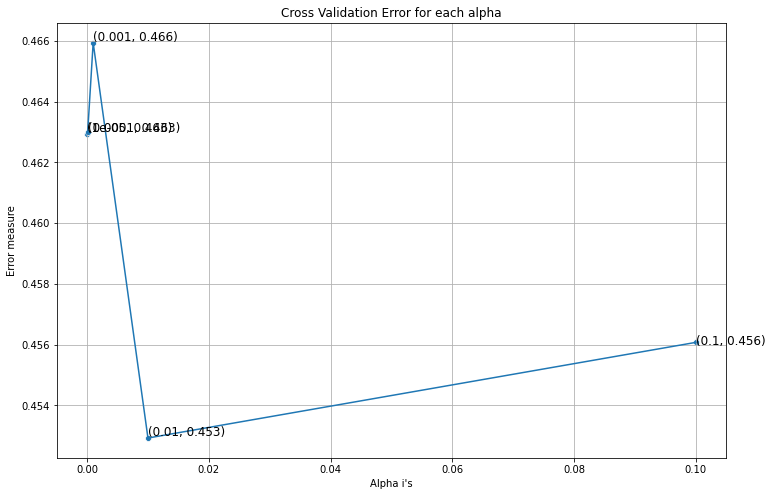

For values of best alpha =  0.01 
Train log loss is : 0.4486762715589084 

For values of best alpha =  0.01 
Test log loss is : 0.45292476674160853 

Total number of test data points : 30000 



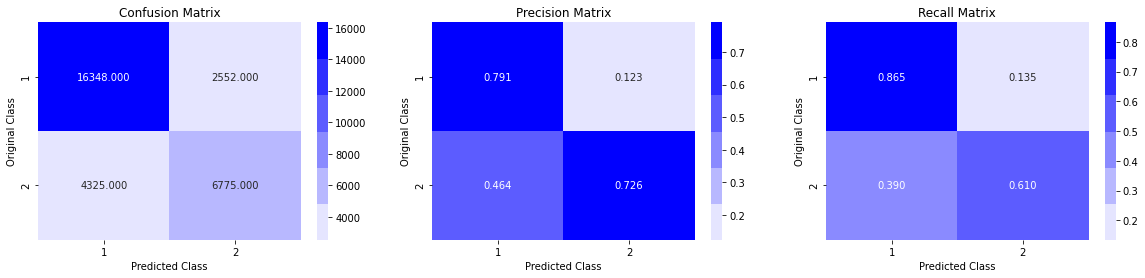

In [0]:
#driver program for linear SVM
#took nearly 4 hours to run with max_eval=20 and alpha = 6 values with log search space
#all trials got succeeded and done using sparktrials(parallelism=2)

search_space = {'alpha':hp.choice('alpha',[10**x for x in range(-5,2)])
                ,'penalty':hp.choice('penalty',['l2']),
                'loss':hp.choice('loss',['hinge'])
                }

Lr_SVM,error_df = sgd_model_hyperopt(X_train, Y_train, X_test, Y_test,search_space,loss='hinge',regularizer='l2',save_name='Hinge_TfidfWeighted')